In [ ]:
#all_slow

In [ ]:
# default_exp johnson2016perceptual

# Perceptual losses for real-time style transfer and super-resolution

Johnson, J., Alahi, A., & Fei-Fei, L. (2016, October). Perceptual losses for real-time style transfer and super-resolution. In European conference on computer vision (pp. 694-711). Springer, Cham.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from itertools import *
import requests
from scipy import linalg
import torch
from torchvision.models.utils import load_state_dict_from_url
import torchvision.models
import torchfile
from fastprogress.fastprogress import master_bar, progress_bar
from fastai.data.external import untar_data
from fastai.data.transforms import get_image_files
from fastai.data import *
from fastai.basics import *
from fastai.vision.all import *
from fastcore.all import *
from fastai.vision.gan import *
from fastai.callback.hook import *
from fastai.callback.progress import *
from fastpapers.core import *
import torch.nn.functional as F

## The data

In [ ]:
path = untar_data(URLs.IMAGENETTE)

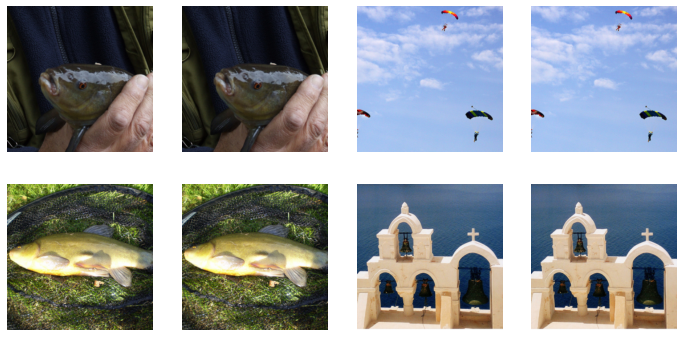

In [ ]:
db = DataBlock(blocks=(ImageBlock, ImageBlock),
               get_items=get_image_files,
               splitter=RandomSplitter(valid_pct=0.01),
               get_x=noop, get_y=noop,
               item_tfms=Resize(256),
               batch_tfms=Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)))
dls = db.dataloaders(path, bs=4, num_workers=4)
dls.show_batch()

For style transfer we have to choose any image as a style target and normlalize it with the `imagenet_stats`.

In [ ]:
#export
artists_sources = {'picasso': 'https://i.pinimg.com/originals/45/e1/c2/45e1c21835ef2bd9b0f4b1a9a0a6ad98.jpg',
                   'hokusai': 'https://canary.contestimg.wish.com/api/webimage/58db571f2beb150ea4d4be44-large.jpg?cache_buster=6748460fdd0b539b8f6366f7f86cc267',
                   'vangogh': 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/2560px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'}

In [ ]:
def get_style_target(artist, size=256, **kwargs):
    r = requests.get(artists_sources[artist], stream=True)
    style_target_img = PILImage.create(r.content)
    p = Pipeline([ToTensor,
                  Resize(size, **kwargs),
                  IntToFloatTensor,
                  Normalize.from_stats(*imagenet_stats, cuda=False)])
    return p(style_target_img), p

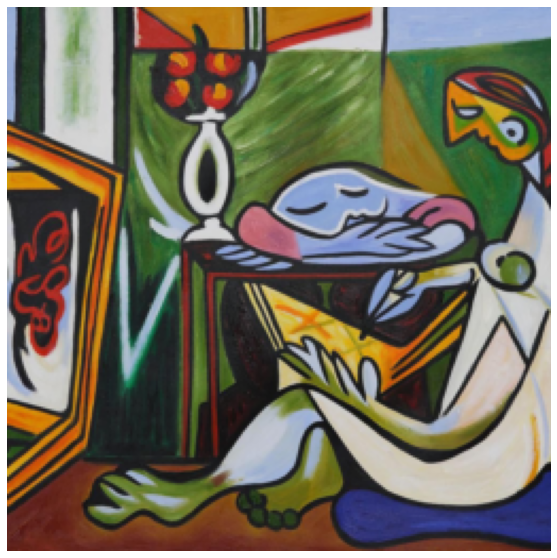

In [ ]:
style_target, p = get_style_target('picasso')
p.decode(style_target)[0].show(figsize=(10,10));

## The Loss

As the autors extracted features from the VGG16 model.

In [ ]:
#export
vgg16 = torchvision.models.vgg16(pretrained=False).features
c, i, j =0, 0, 1
vgg16name2key = {}
for k, l in vgg16._modules.items():
    if isinstance(l, nn.MaxPool2d): 
        vgg16name2key[f'pool{j}'] = k
        j, i, c = j + 1, 0, 0
    if isinstance(l, nn.ReLU):
        i+=1
        vgg16name2key[f'relu{j}_{i}'] = k
    if isinstance(l, nn.Conv2d):
        c+=1
        vgg16name2key[f'conv{j}_{c}'] = k

These are the original weights used in the [paper](https://github.com/jcjohnson/fast-neural-style/blob/master/models/download_vgg16.sh).

In [ ]:
!wget http://cs.stanford.edu/people/jcjohns/fast-neural-style/models/vgg16.t7 -O vgg16.t7

URL transformed to HTTPS due to an HSTS policy
--2020-11-11 17:36:44--  https://cs.stanford.edu/people/jcjohns/fast-neural-style/models/vgg16.t7
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553452665 (528M)
Saving to: ‘vgg16.t7’

vgg16.t7            100%[===================>] 527.81M  14.7MB/s    in 38s     

2020-11-11 17:37:23 (13.8 MB/s) - ‘vgg16.t7’ saved [553452665/553452665]



In [ ]:
#export
if not Path('vgg16.t7').exists():
    r = requests.get('http://cs.stanford.edu/people/jcjohns/fast-neural-style/models/vgg16.t7', stream=True)
    with open('vgg16.t7', 'wb') as f:
        f.write(r.raw.read())

In [ ]:
#export
vgg_lua = torchfile.load('vgg16.t7')
lua_obj = L(vgg_lua._obj[b'modules']).attrgot('_obj')[:31]
lua_state_dict = OrderedDict()
for o in lua_obj.filter(Self.name.startswith(b'conv')):
    name = o.name.decode('ascii')
    l = vgg16name2key[name]
    lua_state_dict[l+'.weight'] = tensor(o[b'weight'])
    lua_state_dict[l+'.bias'] = tensor(o[b'bias'])

The `PerceptualLoss` module computes the feature loss based on `feture_layer` and the style loss on the  `style_layers_names`.

In [ ]:
#export
def gramm_matrix(x):
    bs, c, h, w = x.shape
    x = x.view(bs, c, h*w)
    return x.bmm(x.transpose(1,2)).view(bs, c*c)/(c*h*w)

In [ ]:
#export
def anisotropic_total_variation(x): 
    return  nn.L1Loss(reduction='sum')(x[:,:, 1:,1:],x[:,:,:-1,:-1])/x.shape[0]

In [ ]:
#export
class PerceptualLoss(nn.Module):
    def __init__(self, style_target=None, style_weight=5, feature_weight=1, renormalize=True,
                 feature_layer='relu2_2', style_layers_names=['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'],
                 bs=1, cuda=True, tv_weight=1e-5):
        super().__init__()
        store_attr()
        device = 'cuda' if cuda else 'cpu'
        features = torchvision.models.vgg16(pretrained=False).features
        features.load_state_dict(lua_state_dict)
        max_feature = max((L(style_layers_names) + feature_layer).map(vgg16name2key).map(int))+1
        self.vgg = nn.Sequential(*list(features.children())[:max_feature]).to(device).eval()
        self.vgg = self.vgg.requires_grad_(False)
        if cuda and not style_target is None: 
            self.style_target = self.style_target.to('cuda')
        self.feature_layer = self.vgg._modules[vgg16name2key[feature_layer]]
        self.renorm = Normalize.from_stats(*renorm_stats, cuda=cuda) if renormalize else noop
        self.compute_style = not style_target is None
        if self.compute_style:
            self.setup_style()

    def to(self, *args, **kwargs):
        if self.renormalize:
            self.renorm.mean = self.renorm.mean.to(*args, **kwargs)
            self.renorm.std = self.renorm.std.to(*args, **kwargs)
        if self.compute_style:
            self.Gts = self.Gts.to(*args, **kwargs)
        return super().to(*args, **kwargs)
        
    def setup_style(self):
        self.style_layers = L(self.style_layers_names).map(vgg16name2key).map(self.vgg._modules)
        self.style_target = nn.Parameter(self.style_target, requires_grad=True)
        with Hooks(self.style_layers, lambda m,i,o: o, detach=False) as h:
            y = self.vgg(self.style_target)
            G =  y.new([])
            for phi in h.stored: G = torch.cat([G, gramm_matrix(phi)], dim=1)
        self.Gts = nn.Parameter(G.repeat(self.bs, 1), requires_grad=False)

    def feature_loss(self, output, target):
        with Hook(self.feature_layer, lambda m,i,o: o, detach=False) as h:
            self.vgg(output)
            phi_input = h.stored[0]
            self.vgg(target)
            phi_target = h.stored[0]
        return nn.MSELoss(reduction='mean')(phi_input, phi_target)

    def style_loss(self, output, target):
        with Hooks(self.style_layers, lambda m,i,o: o, detach=False) as h:
            self.vgg(output)
            G = output.new([])
            for phi in h.stored: G = torch.cat([G, gramm_matrix(phi)], dim=1)
        return nn.MSELoss(reduction='sum')(G, self.Gts[:G.shape[0]])/G.shape[0]
    
    def forward(self, output, target):
        output = self.renorm(output)
        target = self.renorm(target)
        feature_loss = self.feature_loss(output, target) if self.feature_weight>0 else tensor(0)
        style_loss = self.style_loss(output, target) if self.compute_style else tensor(0)
        tv_loss = anisotropic_total_variation(output) if self.tv_weight>0 else tensor(0)
        return feature_loss*self.feature_weight + style_loss*self.style_weight + self.tv_weight*tv_loss

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, style_weight=1, bs=4)
input = TensorImage(torch.rand(2, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(2, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

TensorImage(16743.9863, device='cuda:0', grad_fn=<AliasBackward>)

Test that the style image is properly normalized

In [ ]:
style_unnorm = TensorImage(torch.rand(1, 3, 256, 256))
style_imagenet = Normalize.from_stats(*imagenet_stats, cuda=False)(style_unnorm)
style_norm = style_unnorm*2-1 
feature_loss = PerceptualLoss(style_imagenet, renormalize=True, feature_weight=0, cuda=False)
target = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
loss = feature_loss(style_norm, target)
test_eq(loss, 0)

Test that `cuad=True` works

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True)
input = TensorImage(torch.rand(1, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(1, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

TensorImage(83739.4297, device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, bs=4)
input = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

TensorImage(85110.8438, device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, style_weight=1e5, feature_weight=1)
target = TensorImage(torch.rand(1, 3, 256, 256)*2-1).to('cuda')
loss = feature_loss(target, target)
loss

TensorImage(1.6949e+09, device='cuda:0', grad_fn=<AliasBackward>)

In [ ]:
style_target_test = TensorImage(torch.rand(1, 3, 256, 256)*2-1)
feature_loss = PerceptualLoss(style_target_test, renormalize=True, style_weight=1, bs=4)
input = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
target = TensorImage(torch.rand(4, 3, 256, 256)*2-1).cuda()
loss = feature_loss(input, target)
loss

TensorImage(17311.0059, device='cuda:0', grad_fn=<AliasBackward>)

We use `LBFGS` optimization to find the images that mimimize the style loss.

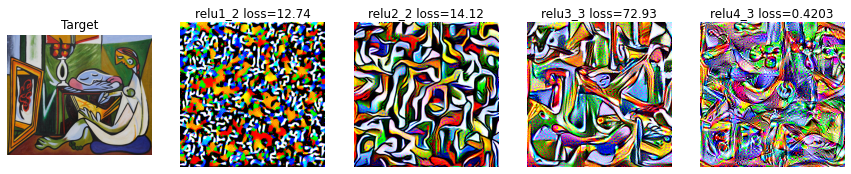

In [ ]:
#hide_input
mb = master_bar(['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])#, 'relu2_2', 'relu3_3', 'relu4_3'
pipe01 = Pipeline([ToTensor(), IntToFloatTensor(), Normalize.from_stats(tensor([0.5, 0.5, 0.5]),tensor([0.5, 0.5, 0.5]), cuda=False)])
samples = L()
samples.append(L(style_target_img, TitledStr('Target')))
for layer in mb:
    loss_func = PerceptualLoss(style_target=style_target, bs=1, feature_weight=0,
                           style_layers_names=[layer], renormalize=True)
    gen_img = (torch.rand(1, 3, 256, 256)-0.5).to('cuda').requires_grad_(True)
    opt = torch.optim.LBFGS([gen_img], lr=0.1)
    for _ in progress_bar(range(500), parent=mb):
        def closure():
            opt.zero_grad()
            gen_img_tanh = nn.Tanh()(gen_img)
            l = loss_func(gen_img_tanh, 1)
            l.backward()
            mb.child.comment = f'{l:.4}'
            return l
        opt.step(closure)
    
    gen_img_tanh = nn.Tanh()(gen_img)
    l = loss_func(gen_img_tanh, 1)
    out = pipe01.decode(TensorImage(gen_img_tanh).cpu())[0];
    samples.append(L(out, TitledStr(f'{layer} loss={l:.4}')))
show_batch(out, None, samples, max_n=len(samples), nrows=1, ncols=len(samples));

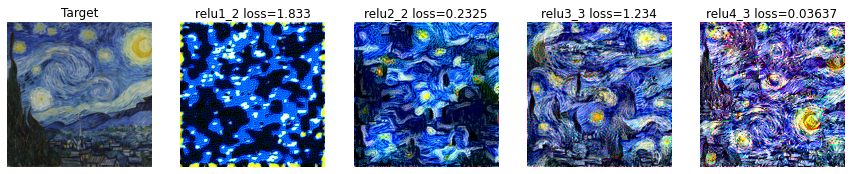

In [ ]:
#hide_input
mb = master_bar(['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
pipe01 = Pipeline([ToTensor(), IntToFloatTensor(), Normalize.from_stats(tensor([0.5, 0.5, 0.5]),tensor([0.5, 0.5, 0.5]), cuda=False)])
samples = L()
style_target, p = get_style_target('vangogh')
style_target_img = p.decode(style_target)[0]
samples.append(L(style_target_img, TitledStr('Target')))
for layer in mb:
    loss_func = PerceptualLoss(style_target=style_target, bs=1, feature_weight=0,
                           style_layers_names=[layer], renormalize=True)
    gen_img = (torch.rand(1, 3, 256, 256)-0.5).to('cuda').requires_grad_(True)
    opt = torch.optim.LBFGS([gen_img], lr=0.1)
    for _ in progress_bar(range(500), parent=mb):
        def closure():
            opt.zero_grad()
            gen_img_tanh = nn.Tanh()(gen_img)
            l = loss_func(gen_img_tanh, 1)
            l.backward()
            mb.child.comment = f'{l:.4}'
            return l
        opt.step(closure)
    
    gen_img_tanh = nn.Tanh()(gen_img)
    l = loss_func(gen_img_tanh, 1)
    out = pipe01.decode(TensorImage(gen_img_tanh).cpu())[0];
    samples.append(L(out, TitledStr(f'{layer} loss={l:.4}')))
show_batch(out, None, samples, max_n=len(samples), nrows=1, ncols=len(samples));

We can also visualize images that minimize the feature reconstruction loss at different layers

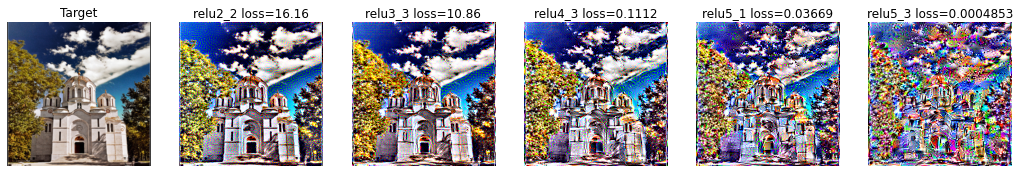

In [ ]:
#hide_input
decoded_target = Resize(256)(dls.dataset[3][0])#b[0][0]
#decoded_target = dls.decode(b)[0][0]
target = pipe01(decoded_target).to('cuda')
samples = L()
samples.append(L(decoded_target, TitledStr('Target')))
mb = master_bar(['relu2_2', 'relu3_3', 'relu4_3', 'relu5_1', 'relu5_3'])
for layer in mb:
    loss_func = PerceptualLoss(style_target=None, bs=1, feature_weight=1, renormalize=True, feature_layer=layer)
    gen_img = (torch.rand(1, 3, 256, 256)*0.1-0.05).to('cuda').requires_grad_(True)
    opt = torch.optim.LBFGS([gen_img], lr=0.1)
    for _ in progress_bar(range(100), parent=mb):
        def closure():
            opt.zero_grad()
            gen_img_tanh = nn.Tanh()(gen_img)
            l = loss_func(gen_img_tanh, target)
            l.backward()
            mb.child.comment = f'{l:.4}'
            return l
        opt.step(closure)

    gen_img_tanh = nn.Tanh()(gen_img)
    l = loss_func(gen_img_tanh, target)
    out = pipe01.decode(TensorImage(gen_img_tanh).cpu())[0];
    samples.append(L(out, TitledStr(f'{layer} loss={l:.4}')))
show_batch(out, None, samples, max_n=len(samples), nrows=1, ncols=len(samples));

## Resnet Generator

The authors use a generator with residual connexions. They used a residual block without the last activation.

In [ ]:
#export
class JohnsonResBlock(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.convpath = nn.Sequential(ConvLayer(n, n, 3, padding_mode='reflect'),
                                       ConvLayer(n, n, 3, padding_mode='reflect', act_cls=None))
    def forward(self, x):
        return self.convpath(x)+x    

In [ ]:
jrb = JohnsonResBlock(32)
x = torch.randn(4, 32, 16, 16)
y = jrb(x)
test_eq(y.shape, x.shape)

In [ ]:
#export
def ResnetGenerator(ni=3, nout=3, nf=32, n_downsamples=2, n_resblocks=5, n_upsamples=2, superres=False):
    layers = [ConvLayer(ni, nf, 9, padding_mode='reflect')]
    for i in range(n_downsamples):
        layers.append(ConvLayer(nf, nf*2, 3, padding_mode='reflect', stride=2))
        nf*=2
    for i in range(n_resblocks):
        layers.append(JohnsonResBlock(nf))
    for i in range(n_upsamples):
        nout = nf if superres else nf//2
        layers.append(ConvLayer(nf, nout, 3, transpose=True, stride=2, output_padding=1, padding=1))
        if not superres: nf//=2
    layers.append(ConvLayer(nf, 3,9, padding_mode='reflect', act_cls=None))
    layers.append(nn.Tanh())
    return nn.Sequential(*layers)

In [ ]:
#hide
style_transfer_generator = ResnetGenerator()
model_sizes(style_transfer_generator, (256, 256))

[torch.Size([1, 32, 256, 256]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 64, 128, 128]),
 torch.Size([1, 32, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256])]

In [ ]:
style_transfer_generator = ResnetGenerator()
x = torch.randn(1, 3, 256, 256)
y = style_transfer_generator(x)
y.shape, y.max(), y.min()

(torch.Size([1, 3, 256, 256]),
 tensor(0.9999, grad_fn=<MaxBackward1>),
 tensor(-0.9999, grad_fn=<MinBackward1>))

## Learning

In [ ]:
#export
class LossToDevice(Callback):
    def before_fit(self):
        if hasattr(self.dls, 'device'): self.loss_func.to(self.dls.device)

In [ ]:
#export
@delegates(Learner)
def style_learner(dls, style_target=None, cbs=None, plkwargs={}, **kwargs):
    model = ResnetGenerator()
    loss_func = PerceptualLoss(style_target=style_target, bs=dls.bs, **plkwargs)
    cbs = L(cbs) + LossToDevice if cbs else LossToDevice
    return Learner(dls, model, loss_func=loss_func, cbs=cbs, **kwargs)

epoch,train_loss,valid_loss,time
0,1087.971069,1066.331787,05:53


epoch,train_loss,valid_loss,time
0,961.684204,947.548340,05:54
1,899.881592,891.020813,05:54
2,873.784180,861.593079,05:54
3,856.660278,841.213074,05:54
4,835.838379,831.628845,05:54
5,827.109192,811.958313,06:02
6,822.523621,814.028870,09:03


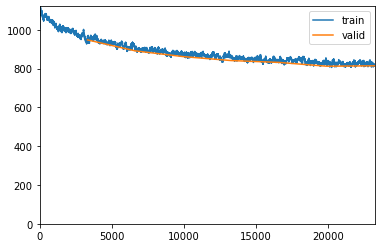

In [ ]:
#hide_output
style_target, _ = get_style_target('picasso')
sgc = ShowGraphCallback()
picasso_learn = style_learner(dls, style_target=style_target, cbs=sgc, plkwargs={'style_weight': 0.5, 'feature_weight':5})
with picasso_learn.removed_cbs(sgc):
    picasso_learn.fit(1, lr=1.e-3)                    
picasso_learn.fit(7, lr=1.e-3)

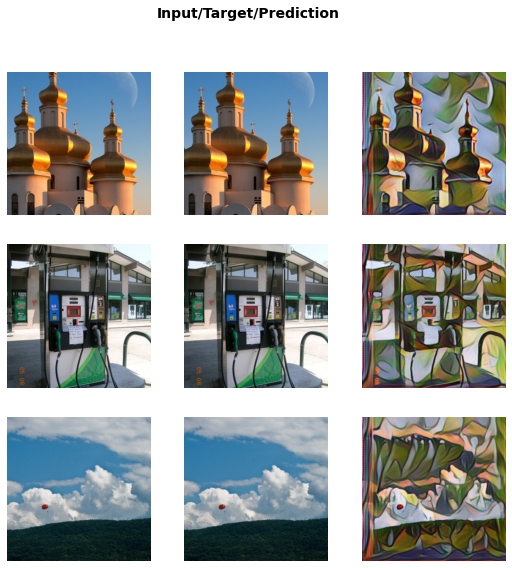

In [ ]:
picasso_learn.show_results()

In [ ]:
#hide
#style_learn.export(f'{artist}_style_transfer.pkl')

## Super-Resolution 4x

In [ ]:
# export
def ResImageBlock(res): 
    '''Like fastai `ImageBlock`, but changes the resolution to `res`.'''
    return TransformBlock(type_tfms=[PILImage.create, Resize(res, ResizeMethod.Squish)], batch_tfms=IntToFloatTensor)

In [ ]:
db = DataBlock(blocks=(ResImageBlock(72), ResImageBlock(288)),
               get_items=get_image_files,
               get_x=noop, get_y=noop,
               batch_tfms=Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)))

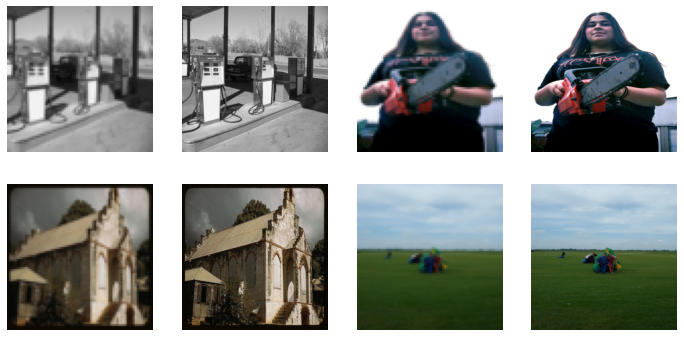

In [ ]:
#hide_output
dls = db.dataloaders(path, bs=4, num_workers=4)
dls.show_batch()
b = dls.one_batch()

In [ ]:
#export
@delegates(Learner)
def superres_learner(dls, superres_factor=4, cbs=None, **kwargs):
    n_upsamples = math.log2(superres_factor)
    assert n_upsamples-int(n_upsamples)==0, 'superres_factor should be a power of 2'
    model = ResnetGenerator(nf=64, n_downsamples=0, n_resblocks=4, n_upsamples=int(n_upsamples), superres=True)
    loss_func = PerceptualLoss(style_weight=0, tv_weight=0)
    cbs = L(cbs) + LossToDevice if cbs else LossToDevice
    return Learner(dls, model, loss_func=loss_func, cbs=cbs, **kwargs)

In [ ]:
#hide_output
learn = superres_learner(dls)
learn.fit(16, lr=1e-3, wd=0)

epoch,train_loss,valid_loss,time
0,32.465317,31.419941,04:10
1,32.269020,28.695124,04:10
2,29.947430,27.630642,04:10
3,29.606182,26.902493,04:10
4,29.762936,26.570440,04:10
5,29.321203,26.501213,04:10
6,26.506901,25.951130,04:10
7,28.176208,26.209173,04:10
8,27.687595,25.540461,04:09
9,31.059582,25.540335,04:09


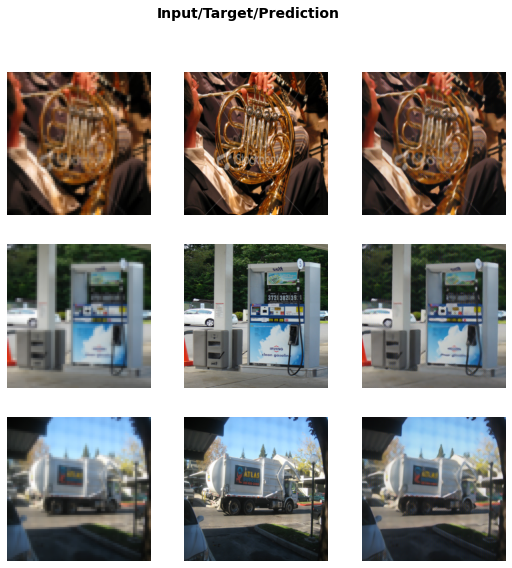

In [ ]:
learn.show_results()

In [ ]:
#hide
#learn.export('superresolution4x.pkl')

## Superres 8x

In [ ]:
db = DataBlock(blocks=(ResImageBlock(36), ResImageBlock(288)),
               get_items=get_image_files,
               get_x=noop, get_y=noop,
               batch_tfms=Normalize.from_stats(0.5*torch.ones(3), 0.5*torch.ones(3)))

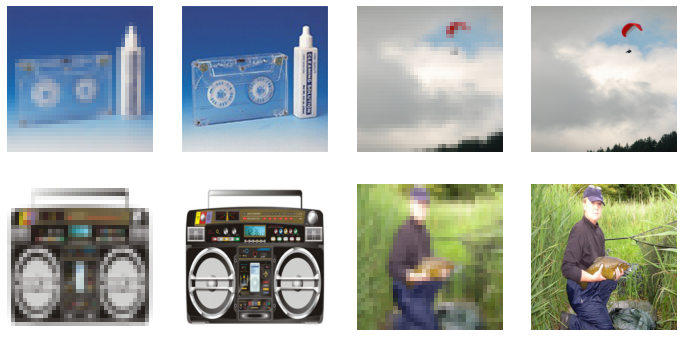

In [ ]:
#hide_output
dls = db.dataloaders(path, bs=4, num_workers=4)
dls.show_batch()
b = dls.one_batch()

In [ ]:
#hide_output
learn = superres_learner(dls, superres_factor=8)
learn.fit(16, lr=1e-3, wd=0)

Using cache found in /home/andres/.cache/torch/hub/pytorch_vision_v0.6.0


epoch,train_loss,valid_loss,time
0,4.294052,4.436052,04:54
1,4.042668,4.040712,06:55
2,4.074093,3.922117,04:21
3,4.171868,3.879687,04:20
4,3.951751,3.826940,04:20
5,4.021472,3.804607,04:20
6,3.832989,3.793207,04:20
7,3.650093,3.788133,04:20
8,3.538365,3.751862,04:20
9,4.025765,3.753390,04:21


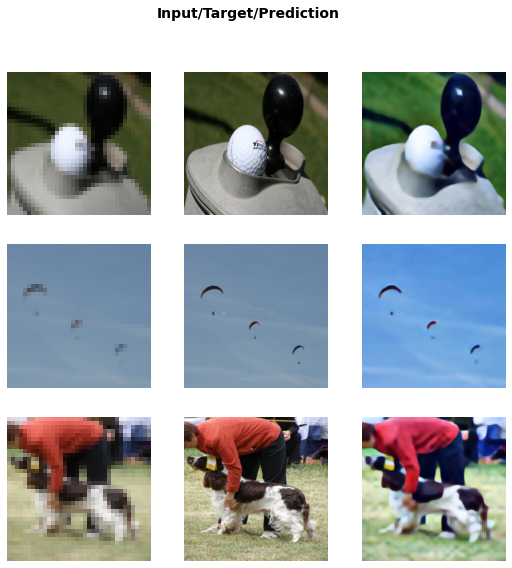

In [ ]:
learn.show_results()

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_isola2017image.ipynb.
Converted 02_heusel2017gans.ipynb.
Converted 03_johnson2016perceptual.ipynb.
Converted 04_carion2020end.ipynb.
Converted index.ipynb.
